In [1]:
import networkx as nx
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import os

In [3]:
# Environment Class
class NetworkEnvironment:
    def __init__(self, topology):
        self.topology = topology
        self.n_nodes = len(topology.nodes)
        self.reset()

    def reset(self):
        self.current_node = np.random.choice(self.n_nodes)
        self.done = False
        return self.current_node

    def step(self, action):
        next_node = action
        if next_node in self.topology[self.current_node]:
            reward = -self.topology[self.current_node][next_node].get('weight', 1)
            self.current_node = next_node
        else:
            reward = -10  # Penalty for invalid action
        if self.current_node == self.n_nodes - 1:  # Assuming the last node is the destination
            self.done = True
            reward = 100
        return self.current_node, reward, self.done

    def get_valid_actions(self):
        return list(self.topology[self.current_node].keys())

In [4]:
# DQN Agent Class
class DQNAgent:
    def __init__(self, n_nodes, n_actions, model_name='dqn_model.weights.h5', learning_rate=0.01, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=32, memory_size=2000):
        self.n_nodes = n_nodes
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = []
        self.memory_size = memory_size
        self.model_name = model_name
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_shape=(self.n_nodes,), activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.n_actions, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        if len(self.memory) > self.memory_size:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, valid_actions):
        if np.random.rand() <= self.epsilon:
            return random.choice(valid_actions)
        act_values = self.model.predict(state)
        return valid_actions[np.argmax(act_values[0][valid_actions])]

    def replay(self):
        minibatch = random.sample(self.memory, min(len(self.memory), self.batch_size))
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self):
        self.model.load_weights(self.model_name)

    def save(self):
        self.model.save_weights(self.model_name)

In [5]:
# Helper Functions
def preprocess_state(state, n_nodes):
    state_vec = np.zeros((1, n_nodes))
    state_vec[0][state] = 1
    return state_vec

In [15]:
def train_dqn_agent(env, agent, n_episodes=50):
    for episode in range(n_episodes):
        state = env.reset()
        state = preprocess_state(state, env.n_nodes)
        total_reward = 0
        for time in range(100):
            valid_actions = env.get_valid_actions()
            action = agent.act(state, valid_actions)
            next_state, reward, done = env.step(action)
            next_state = preprocess_state(next_state, env.n_nodes)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                print(f"Episode: {episode+1}/{n_episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.2f}")
                break
            agent.replay()
    agent.save()

def test_dqn_agent(env, agent, start_node, destination_node):
    state = start_node
    state_vec = preprocess_state(state, env.n_nodes)
    path = [state]
    
    while state != destination_node:
        valid_actions = env.get_valid_actions()
        action = agent.act(state_vec, valid_actions)
        state, _, done = env.step(action)
        path.append(state)
        state_vec = preprocess_state(state, env.n_nodes)
        
        if done or len(path) > env.n_nodes:  # Adding condition to avoid infinite loops
            break
    
    return path

In [6]:
def find_optimal_path(topology, start_node, destination_node):
    # Use Dijkstra's algorithm to find the shortest path
    optimal_path = nx.dijkstra_path(topology, start_node, destination_node, weight='weight')
    return optimal_path

In [7]:
import matplotlib.pyplot as plt
def visualize_graph(topology, path=None):
    pos = nx.spring_layout(topology)
    plt.figure(figsize=(7, 5))
    
    # Draw the graph
    nx.draw(topology, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=16, font_weight='bold')
    nx.draw_networkx_edge_labels(topology, pos, edge_labels={(u, v): f'{d["weight"]}' for u, v, d in topology.edges(data=True)}, font_size=14)

    # Highlight the path if provided
    if path:
        edges_in_path = list(zip(path, path[1:]))
        nx.draw_networkx_edges(topology, pos, edgelist=edges_in_path, edge_color='red', width=3)
    
    plt.show()

Enter the number of nodes:  6
Enter the number of edges:  8


Enter the edges in the format 'node1 node2 weight':


 0 1 4
 1 5 2
 5 4 3
 0 2 12
 0 4 15
 4 3 7
 2 3 8
 2 4 1
Enter the destination node (0 to 5):  0
Enter the start node (0 to 5):  3


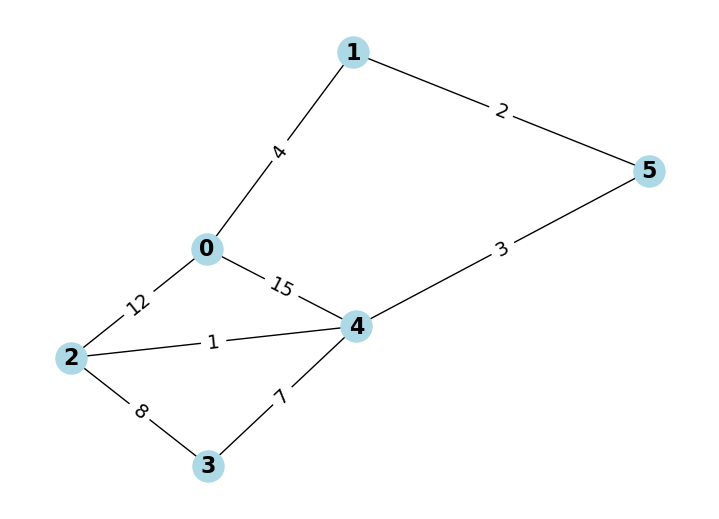

Model already trained. Loading saved model...
Optimal Path: [3, 4, 5, 1, 0]
Visualizing the Optimal path...


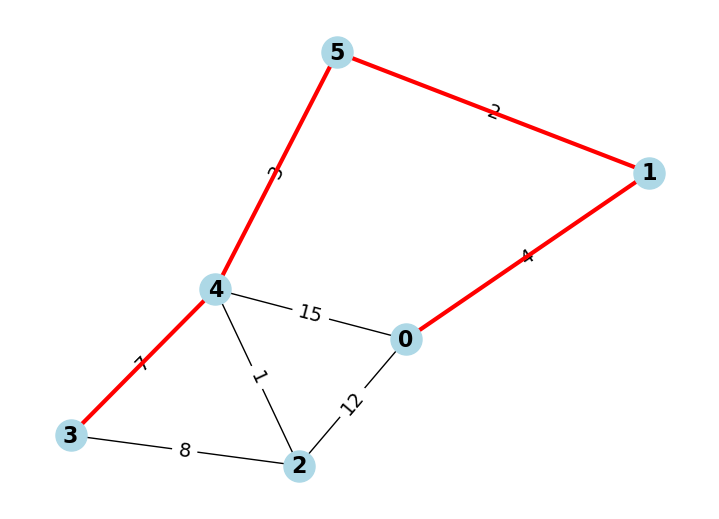

In [40]:
def main():
    topology = nx.Graph()

    # User inputs for nodes and edges
    n_nodes = int(input("Enter the number of nodes: "))
    n_edges = int(input("Enter the number of edges: "))
    
    print("Enter the edges in the format 'node1 node2 weight':")
    for _ in range(n_edges):
        u, v, w = map(int, input().split())
        topology.add_edge(u, v, weight=w)

    destination_node = int(input(f"Enter the destination node (0 to {n_nodes - 1}): "))
    start_node = int(input(f"Enter the start node (0 to {n_nodes - 1}): "))

    # Visualize the initial graph
    visualize_graph(topology)

    # Initialize environment and agent
    env = NetworkEnvironment(topology)
    agent = DQNAgent(n_nodes=n_nodes, n_actions=n_nodes)

    # Load pre-trained model or train a new one
    if not os.path.exists(agent.model_name):
        print("Training the model on initial topology...")
        train_dqn_agent(env, agent)
    else:
        print("Model already trained. Loading saved model...")
        #agent.load()

    # Calculate  optimal path for comparison
    optimal_path = find_optimal_path(topology, start_node, destination_node)
    print("Optimal Path:", optimal_path)
    
    # Visualize the graph with the Optimal path highlighted
    print("Visualizing the Optimal path...")
    visualize_graph(topology, optimal_path)

if __name__ == "__main__":
    main()

In [5]:
import networkx as nx
import plotly.graph_objects as go
import numpy as np

# Define the graph
G = nx.Graph()
edges = [(0, 1, 4), (1, 5, 2), (5, 4, 3), (4, 3, 7), (3, 2, 8), (0, 4, 15), (0, 2, 12), (3, 0, 1)]
G.add_weighted_edges_from(edges)

# Define the optimal path
optimal_path = [3, 4, 5, 1, 0]

# Position the nodes using a layout algorithm
pos = nx.spring_layout(G, seed=42)

# Create Plotly figure
fig = go.Figure()

# Add edges with weights to the figure
for u, v, d in G.edges(data=True):
    fig.add_trace(go.Scatter(x=[pos[u][0], pos[v][0]], y=[pos[u][1], pos[v][1]], 
                             mode='lines', line=dict(width=2, color='black'),
                             showlegend=False))
    mid_x = (pos[u][0] + pos[v][0]) / 2
    mid_y = (pos[u][1] + pos[v][1]) / 2
    fig.add_trace(go.Scatter(x=[mid_x], y=[mid_y], mode='text', text=[f"{d['weight']}"], 
                             textposition='bottom center', showlegend=False))

# Add nodes
fig.add_trace(go.Scatter(
    x=[pos[node][0] for node in G.nodes()],
    y=[pos[node][1] for node in G.nodes()],
    mode='markers+text',
    marker=dict(size=10, color='lightblue'),
    text=[str(node) for node in G.nodes()],
    textposition='top center',
    showlegend=False
))

# Create animation frames
frames = []
num_dots = 15  # Number of dots in the trail
duration_per_segment = 200  # Duration per frame in milliseconds

for i in range(len(optimal_path) - 1):
    u, v = optimal_path[i], optimal_path[i + 1]
    
    # Generate coordinates along the path
    x_values = np.linspace(pos[u][0], pos[v][0], num=num_dots)
    y_values = np.linspace(pos[u][1], pos[v][1], num=num_dots)
    
    # Create frames for the moving dots
    for j in range(num_dots):
        # Generate dot positions
        x_pos = x_values[max(0, j - num_dots + 1):j + 1]
        y_pos = y_values[max(0, j - num_dots + 1):j + 1]
        
        frames.append(go.Frame(
            data=[
                go.Scatter(x=x_pos, y=y_pos, 
                           mode='markers', 
                           marker=dict(size=10, color='red'),
                           showlegend=False)
            ],
            name=f"Step {i + 1}_Frame_{j}"
        ))

# Add frames to the figure
fig.frames = frames

# Add play and pause buttons
fig.update_layout(
    updatemenus=[{
        'buttons': [
            {
                'label': 'Play',
                'method': 'animate',
                'args': [None, {
                    'frame': {'duration': duration_per_segment, 'redraw': True},
                    'fromcurrent': True
                }]
            },
            {
                'label': 'Pause',
                'method': 'animate',
                'args': [[None], {
                    'frame': {'duration': 0, 'redraw': True},
                    'mode': 'immediate',
                    'transition': {'duration': 0}
                }]
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': True,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }]
)

# Update layout for better visualization
fig.update_layout(
    title="Data Transmission Simulation along Optimal Path",
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    showlegend=False
)

# Show the plot
fig.show()
